In [1]:
import scipy.io as io
import pylab as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np

In [2]:
# dinh nghia cac tham so mac dinh
VALIDATION_SIZE = 14652
BATCH_SIZE = 10
TRAINING_INTERS = 20
BATCH_SIZE = 100
N_INPUT = 32
N_CLASSES = 10

In [3]:
def prepare_data():
    train_data = io.loadmat('../data/svhn_train_32x32.mat', variable_names='X').get('X')
    train_data = np.swapaxes(orig_np_array, )
    train_label = io.loadmat('../data/svhn_train_32x32.mat', variable_names='y').get('y')
    test_data = io.loadmat('../data/svhn_test_32x32.mat', variable_names='X').get('X')
    test_data = tf.transpose(test_data, [3, 0, 1, 2])
    test_label = io.loadmat('../data/svhn_test_32x32.mat', variable_names='y').get('y')
    validation_data = train_data[:VALIDATION_SIZE]
    validation_label = train_label[:VALIDATION_SIZE]
    train_data = train_data[VALIDATION_SIZE:]
    train_label = train_label[VALIDATION_SIZE:] 
    return {'data': train_data, 'label': train_label},{'data': validation_data, 'label': validation_label},{'data': test_data, 'label': test_label}

In [12]:
# Lay va phan chia data tu file
train_set, validation_set, test_set = prepare_data()


In [16]:
with tf.Session() as sess:
    sess.run([train_set['data'][0]])


In [5]:
def show_image(value):
    plt.figure(1)
    im = plt.imshow(value)
    plt.show()

TypeError: Image data cannot be converted to float

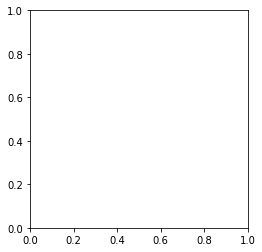

In [6]:
# hien thi hinh anh
img_num = 1
show_image(train_set['data'][img_num])
print(train_set['label'][img_num])

In [ ]:
# Xay dung mo hinh cnn su dung slim
def cnn(input, is_training=True):
    # su dung arg_scope de chac chan rang moi layer chi su dung cung mot gia tri cua cac parameter
    with slim.arg_scope([slim.conv2d, slim.fully_connected], 
                            normalizer_fn=slim.batch_norm,
                            weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                            weights_regularizer=slim.l2_regularizer(0.0005)):
    
        with slim.arg_scope([slim.conv2d], padding='SAME'):
            net = slim.conv2d(input, 32, [5, 5], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.conv2d(net, 64, [5, 5], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.flatten(net, scope='flatten3')
            
        net = slim.fully_connected(net, 1024, scope='fc3')
        net = slim.dropout(net, is_training=is_training, scope='dropout3')  # 0.5 by default
        outputs = slim.fully_connected(net, 10, activation_fn=None, normalizer_fn=None, scope='fco')
        
    return outputs

In [ ]:
# graph input
input = tf.placeholder(tf.float32, [None, N_INPUT, N_INPUT, 3])
# graph label
label = tf.placeholder(tf.float32, [None, N_CLASSES])

# predict
pred = cnn(input)

In [ ]:
# tu dong tim kiem learning_rate phu hop
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
            1e-4,  # Base learning rate.
            global_step * BATCH_SIZE,  # Current index into the dataset.
            train_set['data'].shape[3],  # Decay step.
            0.95,  # Decay rate.
            staircase=True)

# dinh nghia cac ham mat mat
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=label))
optimal = tf.train.AdamOptimizer(learning_rate)
train_op = optimal.minimize(loss_op, global_step=global_step)

In [ ]:
# danh gia model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# tao summary cua cac monitor de quan sat cac bien
tf.summary.scalar('loss_op', loss_op)
tf.summary.scalar('learning_rate', learning_rate)
tf.summary.scalar('accuracy', accuracy)

# gop cac summaries vao mot operation
merged_summary_op = tf.summary.merge_all()

# tao doi tuong log writer va ghi vao Tensorboard
writer = tf.summary.FileWriter('./checkpoint', graph=tf.get_default_graph())

In [ ]:
# khoi tao cac variables
init = tf.global_variables_initializer()
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    avg_cost = 0.
    avg_acc = 0.
    train_len = train_set['data'].shape[3]
    # Training cycle
    for epoch in range(TRAINING_INTERS):
        total_batch =  train_len // BATCH_SIZE
        for batch in range(total_batch):
            # lay batch tiep theo
            batch_input = train_set['data'][:,:,:,batch*BATCH_SIZE:min((batch+1)*BATCH_SIZE,train_len)]
            batch_label = train_set['label'][batch*BATCH_SIZE:min((batch+1)*BATCH_SIZE,train_len)]
           
            # chay train_op, loss_op, accuracy
            _, cost, acc, summary = sess.run([train_op, loss_op, accuracy, merged_summary_op], feed_dict={input:batch_input, label:batch_label})
            # Compute average loss and accuracy
            avg_cost += cost / total_batch
            avg_acc += acc / total_batch
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * total_batch + batch)
        
        # hien thi ket qua sau moi epoch
        print("Epoch:", '%04d,' % (epoch + 1), "cost={:.9f}, training accuracy %.5f" % (avg_cost, avg_acc))
        break
    
    print('Optimization completed!!!')
    # Luu tru variables vao disk.
    save_path = saver.save(sess, "/cnn_model.ckpt")
    print("Model saved in path: %s" % save_path)

In [ ]:
# Su dung model da duoc luu de tien doan
with tf.Session() as sess:
    saver.restore(sess, save_path)
    